In [81]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [82]:
import math
import copy
import random
from dataclasses import dataclass

In [83]:
from algo.dynamicProgramming import dynamicPlayer
from algo.iplayer import RandomPlayer, IPlayer
from algo.q_learning import QLearning
from algo.board import Board, GameState

In [84]:
device = torch.device(
    # "cuda" if torch.cuda.is_available() else
    # "mps" if torch.backends.mps.is_available() else
    "cpu"
)
device

device(type='cpu')

In [85]:
class DQN(nn.Module):
	"""
	Using structure similar to NNUE:
	https://www.chessprogramming.org/File:StockfishNNUELayers.png
	
	Observation space: hot-encoded board:
	for each of 18 cells we can be -2, -1, 0, 1, 2 (5 possibilities).
	In total it gives 18 * 5 = 90 possible inputs, out of which at most 12 are on.
	
	# Action space: 4 possible actions.
	Value function: 1 output. # https://www.reddit.com/r/reinforcementlearning/comments/1b1te73/help_me_understand_why_use_a_policy_net_instead/
	"""

	def __init__(self):
		super(DQN, self).__init__()

		layer_sizes = [
			180,
			50,
			50,
			1
		]

		layers = []
		prev_size = layer_sizes[0]
		for cur_size in layer_sizes[1:]:
			layers.append(nn.Linear(prev_size, cur_size))
			prev_size = cur_size

		self.layers = nn.ModuleList(layers)

	def forward(self, cur_board: Board, next_board: Board) -> torch.Tensor:
		state = torch.cat([
			cur_board.to_tensor(device),
			next_board.to_tensor(device)
		])
		# state = cur_board.to_tensor(device)
		for layer in self.layers[:-1]:
			state = F.relu(layer(state))
		return self.layers[-1](state)

In [86]:
def make_environment_step(state: Board, action: tuple[tuple[int, int], tuple[int, int]], enemy: IPlayer) -> tuple[Board, torch.Tensor]:
	"""
	Returns new state and reward for the given action.
	"""
	state = copy.deepcopy(state)
	cur_sign = state.turn_sign

	piece_stats = {piece: 0 for piece in range(-2, 3)}
	for _, piece in state:
		piece_stats[piece] -= 1

	state.make_move(*action)

	reward = 0
	for pos, piece in state:
		if (cur_sign == 1 and piece == 2 and pos[1] > 4) or \
			(cur_sign == -1 and piece == -2 and pos[1] < 1):
			reward -= 3

	while state.game_state == GameState.NOT_OVER and state.turn_sign != cur_sign:
		state.make_move(*enemy.decide_move(state))
		
	for _, piece in state:
		piece_stats[piece] += 1
	
	reward += 6 * piece_stats[2 * cur_sign] + 2 * piece_stats[cur_sign] \
			- piece_stats[-cur_sign] - 2 * piece_stats[-2 * cur_sign]

	if state.game_state != GameState.NOT_OVER:
		# our_pieces = 0
		# enemy_pieces = 0
		# for _, piece in state:
		# 	if piece == cur_sign:
		# 		our_pieces += 1
		# 	elif piece == -cur_sign:
		# 		enemy_pieces += 1
		# 	elif piece == 2 * cur_sign:
		# 		our_pieces += 2
		# 	elif piece == -2 * cur_sign:
		# 		enemy_pieces += 2
			
		# reward += 3 * our_pieces / (enemy_pieces + 1)

		if state.game_state == GameState.DRAW:
			reward -= 40
		elif state.game_state == GameState(cur_sign):
			reward += 40
		elif state.game_state == GameState(-cur_sign):
			reward -= 40
		else:
			raise ValueError("Unexpected game state")
	
	return state, torch.Tensor([reward])

In [87]:
GAMMA = 0.99 # discount rate

@dataclass
class Action:
	action: tuple[tuple[int, int], tuple[int, int]]
	value: torch.Tensor

def q_s(dqn: DQN, current_state: Board) -> list[Action]:
	"""
	Return: list[(new_state, action, immediate_reward, value)]
	"""
	ret: list[Action] = []
	for s in current_state.get_possible_pos():
		for e in current_state.get_correct_moves(s):
			next_state = copy.deepcopy(current_state)
			next_state.enable_update_should_capture = False
			# immediate_reward = torch.tensor([next_state.make_move(s, e) * next_state.turn_sign], device=device)
			# value = dqn(next_state) * GAMMA + immediate_reward
			next_state.make_move(s, e)
			value = dqn(current_state, next_state)
			ret.append(Action((s, e), value))
	return ret

In [88]:
BATCH_SIZE = 128 # number of transitions sampled from the replay buffer

EPS_START = 0.9 # exploration rate
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.0005 # update rate
LR = 1e-4 # AdamW learning rate

policy_net = DQN().to(device) # to be updated often
target_net = DQN().to(device) # to be updated with TAU
# policy_net.load_state_dict(torch.load("dqn86 90 50 50 1.pth"))
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
steps_done = 0


def select_action(board: Board) -> Action:
	global steps_done
	sample = random.random()
	eps_threshold = EPS_END + (EPS_START - EPS_END) * \
		math.exp(-1. * steps_done / EPS_DECAY)
	steps_done += 1
	if sample > eps_threshold:
		with torch.no_grad():
			state_values = q_s(policy_net, board)
			return max(state_values, key=lambda x: x.value.item())
					
	else:
		possible_moves = []
		for s in board.get_possible_pos():
			for e in board.get_correct_moves(s):
				possible_moves.append((s, e))
		return Action(
			random.choice(possible_moves),
			torch.tensor([0], device=device)
		)

In [89]:
@dataclass
class TransitionRecord:
	current_state: Board
	next_state: Board
	immediate_reward: torch.Tensor

def optimize_model(memory: list[TransitionRecord]):
	if len(memory) < BATCH_SIZE:
		return
	
	state_action_values = []
	expected_state_action_values = []

	for r in random.sample(memory, BATCH_SIZE):
		# Compute Q(s_t, a) - the model computes Q(s_t), then we select the
		# columns of actions taken. These are the actions which would've been taken
		# for each batch state according to policy_net
		state_action_values.append(max(q_s(policy_net, r.current_state), key=lambda x: x.value.item()).value)

		# Compute V(s_{t+1}) for all next states.
		# Expected values of actions for non_final_next_states are computed based
		# on the "older" target_net; selecting their best reward with max(1).values
		# This is merged based on the mask, such that we'll have either the expected
		# state value or 0 in case the state was final.
		next_state_value = 0
		if r.next_state.game_state == GameState.NOT_OVER:
			with torch.no_grad():
				next_state_value = max(q_s(target_net, r.next_state), key=lambda x: x.value.item()).value
		# Compute the expected Q values
		expected_state_action_values.append((next_state_value * GAMMA) + r.immediate_reward)

	# Compute Huber loss
	criterion = nn.SmoothL1Loss()
	loss = criterion(
		torch.cat(state_action_values),
		torch.cat(expected_state_action_values)
	)

	print("Loss:", loss.item())

	# Optimize the model
	optimizer.zero_grad()
	loss.backward()
	# In-place gradient clipping
	torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
	optimizer.step()

In [90]:
memory: list[TransitionRecord] = []
win_rate = []

In [91]:
# TAU = 0.001

if torch.cuda.is_available() or torch.backends.mps.is_available():
	num_episodes = 1000
else:
	num_episodes = 50
	
# memory: list[TransitionRecord] = []

# win_rate = []

win_stats = []

q_enemy = QLearning("~dqn86 90 50 50 1 tuned on Yeet.pth", [90, 50, 50, 1])

for i_episode in range(num_episodes):
	rand_enemy = RandomPlayer(random.randint(2, 100) * i_episode)
	# Initialize the environment and get its state
	cur_state = Board()
	for _ in range(random.randint(0, 4)):
		cur_state.make_move(*rand_enemy.decide_move(cur_state))

	# if sum(win_rate[-20:]) < 16:
	# 	enemy = rand_enemy
	# else:
	# 	enemy = q_enemy

	enemy = q_enemy
	# enemy = rand_enemy

	# if i_episode % 2 == 0:
	# 	our_sign = -1
	# 	cur_state.make_move(*enemy.decide_move(cur_state))
	# else:
	# 	our_sign = 1

	our_sign = cur_state.turn_sign
	
	while True:
		action = select_action(cur_state)
		new_state, immediate_reward = make_environment_step(cur_state, action.action, enemy)

		memory.append(TransitionRecord(cur_state, new_state, torch.tensor([immediate_reward], device=device)))
		cur_state = new_state

		if cur_state.game_state != GameState.NOT_OVER:
			win_rate.append(cur_state.game_state == GameState(our_sign))
			
			pieces = 0
			for _, piece in cur_state:
				pieces += piece != 0
			win_stats.append(pieces * (1 if cur_state.game_state == GameState(our_sign) else -1))

			break

	# Perform one step of the optimization (on the policy network)
	optimize_model(memory)

	# Soft update of the target network's weights
	# θ′ ← τ θ + (1 −τ )θ′
	target_net_state_dict = target_net.state_dict()
	policy_net_state_dict = policy_net.state_dict()
	for key in policy_net_state_dict:
		target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
	target_net.load_state_dict(target_net_state_dict)

	print(f"Episode {i_episode} finished. {sum(win_rate[-20:])}/{20}")

print('Complete')

Episode 0 finished. 0/20
Episode 1 finished. 1/20
Episode 2 finished. 2/20
Episode 3 finished. 2/20
Episode 4 finished. 3/20
Episode 5 finished. 4/20
Episode 6 finished. 4/20
Episode 7 finished. 4/20
Loss: 2.397663116455078
Episode 8 finished. 4/20
Loss: 3.3390848636627197
Episode 9 finished. 5/20
Loss: 2.40531849861145
Episode 10 finished. 5/20
Loss: 1.9883025884628296
Episode 11 finished. 5/20
Loss: 2.8605282306671143
Episode 12 finished. 6/20
Loss: 3.021317958831787
Episode 13 finished. 6/20
Loss: 4.066917896270752
Episode 14 finished. 6/20
Loss: 4.218421936035156
Episode 15 finished. 6/20
Loss: 3.9366660118103027
Episode 16 finished. 6/20
Loss: 2.751877784729004
Episode 17 finished. 7/20
Loss: 3.2872915267944336
Episode 18 finished. 7/20
Loss: 3.6562118530273438
Episode 19 finished. 7/20
Loss: 2.7349114418029785
Episode 20 finished. 7/20
Loss: 3.324559211730957
Episode 21 finished. 6/20
Loss: 4.451777458190918
Episode 22 finished. 5/20
Loss: 3.8047499656677246
Episode 23 finished. 

KeyboardInterrupt: 

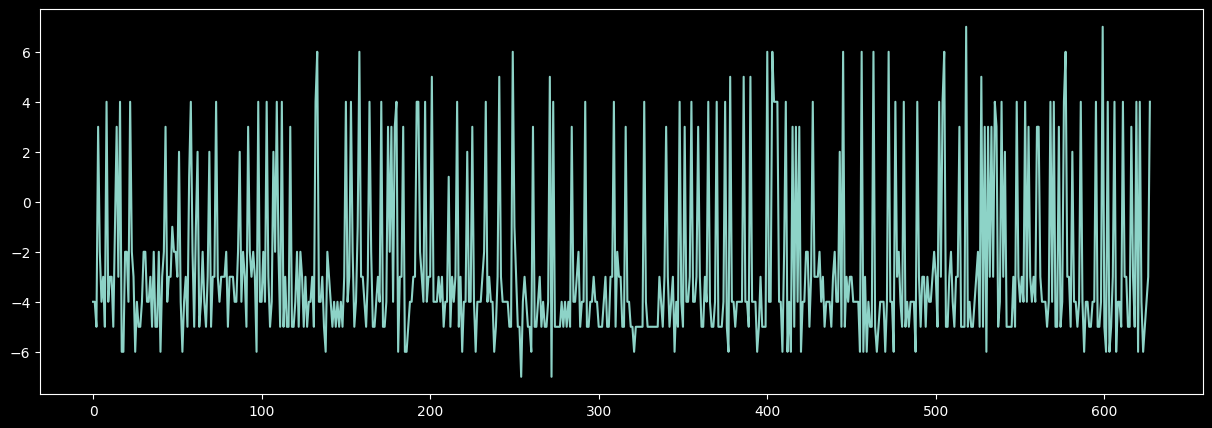

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(win_stats)

In [76]:
sum(win_rate) / len(win_rate)

0.18152866242038215

In [77]:
len(win_rate)

628

In [78]:
sum(win_rate)

114

In [ ]:
stats = []

enemy = RandomPlayer(random.randint(0, 20000))
# enemy = QLearning("90_52_1_9130.pth", [90, 52, 1])

for i in range(100):
	board = Board()

	for _ in range(random.randint(0, 1)):
		board.make_move(*enemy.decide_move(board))
	
	our_sign = board.turn_sign

	while board.game_state == GameState.NOT_OVER:
		while board.game_state == GameState.NOT_OVER and board.turn_sign == our_sign:
			with torch.no_grad():
				state_values = max(q_s(target_net, board), key=lambda x: x.value.item())
				board.make_move(*state_values.action)
		while board.game_state == GameState.NOT_OVER and board.turn_sign != our_sign:
			board.make_move(*enemy.decide_move(board))
	
	stats.append(board.game_state == GameState(our_sign))

sum(stats), len(stats)

(58, 100)